# importing libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.layers import Dense, LSTM

# load the dataset

In [ ]:
df=pd.read_csv("Tesla.csv - Tesla.csv.csv")
df

In [4]:
df1=df.reset_index()['Close']
df1

0        23.889999
1        23.830000
2        21.959999
3        19.200001
4        16.110001
           ...    
1687    246.169998
1688    258.000000
1689    255.729996
1690    262.049988
1691    261.500000
Name: Close, Length: 1692, dtype: float64

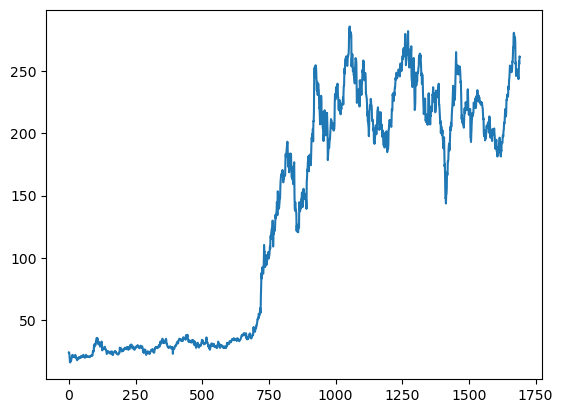

In [5]:
plt.plot(df1)

# we apply MinMax scaler

In [6]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
print(df1)

[[0.02993635]
 [0.02971433]
 [0.02279455]
 ...
 [0.88784039]
 [0.91122698]
 [0.9091918 ]]


# Splitting dataset into train and test data

In [7]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

print("Training Size is: ", training_size)
print("Test Size is: ", test_size)

Training Size is:  1099
Test Size is:  593


# Convert an array of values to dataset matrics

In [8]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Reshaping into X=t,t+1,t+2,t+3 and Y=t+4

In [9]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [10]:
print("Reshaped X_train: ", X_train.shape)
print("Reshaped y_train: ", y_train.shape)
print("Reshaped X_test: ", X_test.shape)
print("Reshaped y_test: ", y_test.shape)

Reshaped X_train:  (998, 100)
Reshaped y_train:  (998,)
Reshaped X_test:  (492, 100)
Reshaped y_test:  (492,)


# reshape inputs

In [11]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# Create the Stacked LSTM model

In [12]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
model.fit(X_train,y_train, validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
16/16 [==============================] - 10s 245ms/step - loss: 0.0318 - val_loss: 0.0216
Epoch 2/100
16/16 [==============================] - 3s 174ms/step - loss: 0.0039 - val_loss: 0.0052
Epoch 3/100
16/16 [==============================] - 3s 172ms/step - loss: 0.0022 - val_loss: 0.0049
Epoch 4/100
16/16 [==============================] - 3s 164ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 5/100
16/16 [==============================] - 3s 160ms/step - loss: 0.0017 - val_loss: 0.0036
Epoch 6/100
16/16 [==============================] - 3s 159ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 7/100
16/16 [==============================] - 2s 157ms/step - loss: 0.0015 - val_loss: 0.0039
Epoch 8/100
16/16 [==============================] - 2s 158ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 9/100
16/16 [==============================] - 3s 164ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 10/100
16/16 [==============================] - 3s 163ms/step - loss: 0.0013 - val_l

# Model prediction and performance metrics

In [14]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

16/16 [==============================] - 0s 23ms/step


# Back to original form (matrics to values)


In [15]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

# Calculate root mean square error

In [16]:
import math
from sklearn.metrics import mean_squared_error
print("RMSE VALUE for training data is :",math.sqrt(mean_squared_error(y_train,train_predict)))
print("RMSE VALUE for training data is :",math.sqrt(mean_squared_error(y_test,test_predict)))


RMSE VALUE for training data is : 119.46340946129978
RMSE VALUE for training data is : 223.80859978850816


# Visualize train and test pattern

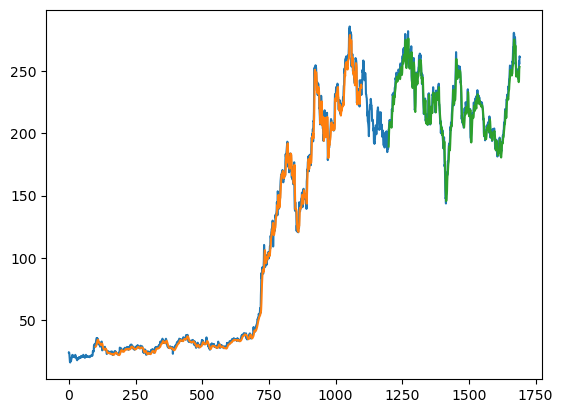

In [17]:
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


In [18]:
len(test_data)


593

In [32]:
x_input=test_data[6:].reshape(1,-1)
x_input.shape

(1, 587)

# Temporary input

In [55]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [34]:
temp_input

[0.8813646686934502,
 0.8951302691823105,
 0.8582741166205334,
 0.861863525914847,
 0.8399200393750728,
 0.8544996792092321,
 0.8595692283299177,
 0.8608643955455167,
 0.8463587787994782,
 0.798697423814843,
 0.7979203146044892,
 0.7900384691002582,
 0.786264031688957,
 0.769353167835337,
 0.7347542717111144,
 0.7441163125479321,
 0.7180283804682674,
 0.7144760160217432,
 0.7075192185920923,
 0.6965659662925782,
 0.6735124035612359,
 0.7031527555936398,
 0.749185865369032,
 0.7529972847210792,
 0.7652457042361925,
 0.7592140103873368,
 0.7639875226617536,
 0.7845618707036085,
 0.7767539964816979,
 0.7638765139324725,
 0.7645426181139595,
 0.7530713115096145,
 0.7189534840490626,
 0.7233569881948901,
 0.7221358440674119,
 0.7209146999399337,
 0.7062610925238683,
 0.6897942598869584,
 0.6973430792033463,
 0.6545662970282095,
 0.6515319313803012,
 0.6559724729730897,
 0.6517539488388634,
 0.668923923104221,
 0.6876109710313101,
 0.686389826903832,
 0.7058540432479041,
 0.703744781180791,


# Demonstrate prediction for next 10 days

In [67]:
from numpy import array

lst_output=[]
n_steps=585
i=0
while(i<30):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape(1,n_steps,1)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    print(lst_output)


0 day input [0.85827412 0.86186353 0.83992004 0.85449968 0.85956923 0.8608644
 0.84635878 0.79869742 0.79792031 0.79003847 0.78626403 0.76935317
 0.73475427 0.74411631 0.71802838 0.71447602 0.70751922 0.69656597
 0.6735124  0.70315276 0.74918587 0.75299728 0.7652457  0.75921401
 0.76398752 0.78456187 0.776754   0.76387651 0.76454262 0.75307131
 0.71895348 0.72335699 0.72213584 0.7209147  0.70626109 0.68979426
 0.69734308 0.6545663  0.65153193 0.65597247 0.65175395 0.66892392
 0.68761097 0.68638983 0.70585404 0.70374478 0.67928504 0.70085846
 0.69493783 0.72209886 0.74955593 0.75025902 0.75928803 0.74585551
 0.74629955 0.74189604 0.72898163 0.69227353 0.6955669  0.69771314
 0.69812019 0.7249482  0.74493041 0.70877734 0.69682502 0.69552986
 0.7082223  0.69397569 0.67173622 0.67998813 0.69064534 0.6839476
 0.6589698  0.64786856 0.64579633 0.65845174 0.64857164 0.6397276
 0.66570453 0.66211512 0.68424364 0.66551949 0.67451153 0.68024718
 0.68798103 0.66052397 0.64612936 0.6261101  0.646721

In [61]:
day_new=np.arange(1,1)
day_pred=np.arange(11,11)

In [45]:
len(df1)

1692

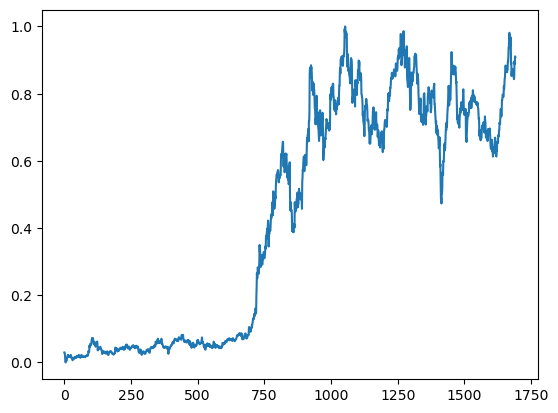

In [43]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[0:])

In [47]:
df3=scaler.inverse_transform(df3).tolist()

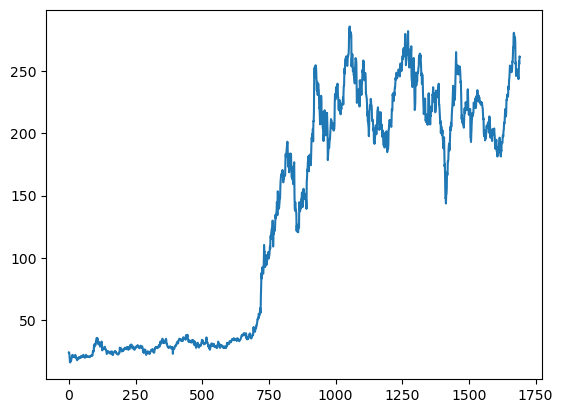

In [48]:
plt.plot(df3)